# Pull Request Reponse in Time interval

This visualization builds on the idea of the time to first resposne to prs. This visualization will plot the number of open prs, and the number of prs that are waiting for a response from the pr creator or has been responded to by another person in num days 

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import datetime
import plotly.graph_objects as go
#import dash
import plotly.express as px
#from jupyter_dash import JupyterDash
#from dash import dcc
#from dash import html
#from dash.dependencies import Input, Output
import datetime as dt
import plotly

with open("../../copy_cage-padres.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

This will allow you to get specific repo_ids. A few are listed for ease of use

In [3]:
repo_urls = ['https://github.com/ansible/ansible','https://github.com/pulp/pulp-infra-ansible'
             ,'https://github.com/agroal/agroal','https://github.com/chaoss/augur']

url_query = str(repo_urls)
url_query = url_query[1:-1]

repo_query = salc.sql.text(f"""
        SET SCHEMA 'augur_data';
        SELECT DISTINCT
            r.repo_id,
            r.repo_name
        FROM
            repo r
        JOIN repo_groups rg 
        ON r.repo_group_id = rg.repo_group_id
        WHERE
            r.repo_git in({url_query})
        """)

t = engine.execute(repo_query)
results = t.all()
repo_ids = [ row[0] for row in results]
repo_names = [ row[1] for row in results]
print(repo_ids)
print(repo_names)

[27515, 28336, 32983, 36113]
['pulp-infra-ansible', 'ansible', 'agroal', 'augur']


Below is the query used in the callback. Can copy and paste any query here

In [4]:
repo_statement = str([36113])
repo_statement = repo_statement[1:-1]

query = salc.sql.text(f"""
                SELECT
                        pr.pull_request_id,
                        pr.repo_id AS ID,
                        pr.pr_augur_contributor_id AS cntrb_id,
                        M.msg_timestamp,
                        M.msg_cntrb_id,
                        pr.pr_created_at,
                        pr.pr_closed_at
                    FROM
                        pull_requests pr
                    LEFT OUTER JOIN
                        (
                            SELECT
                                prr.pull_request_id AS pull_request_id,
                                m.msg_timestamp AS msg_timestamp,
                                m.cntrb_id AS msg_cntrb_id
                            FROM
                                pull_request_review_message_ref prrmr,
                                pull_requests pr,
                                message m,
                                pull_request_reviews prr
                            WHERE
                                prrmr.pr_review_id = prr.pr_review_id AND
                                prrmr.msg_id = m.msg_id AND
                                prr.pull_request_id = pr.pull_request_id
                            UNION ALL
                            SELECT
                                prmr.pull_request_id AS pull_request_id,
                                m.msg_timestamp AS msg_timestamp,
                                m.cntrb_id AS msg_cntrb_id
                            FROM
                                pull_request_message_ref prmr,
                                pull_requests pr,
                                message m
                            WHERE
                                prmr.pull_request_id = pr.pull_request_id AND
                                prmr.msg_id = m.msg_id
                        ) M
                        ON
                            M.pull_request_id = pr.pull_request_id
                    WHERE
                        pr.repo_id in ({repo_statement})
                """)
df = pd.read_sql(query, con=engine)

df["cntrb_id"] = df["cntrb_id"].astype(str)
df["cntrb_id"] = df["cntrb_id"].str[:15]

df["msg_cntrb_id"] = df["msg_cntrb_id"].astype(str)
df["msg_cntrb_id"] = df["msg_cntrb_id"].str[:15]

# convert to datetime objects rather than strings
df["msg_timestamp"] = pd.to_datetime(df["msg_timestamp"], utc=True)
df["pr_created_at"] = pd.to_datetime(df["pr_created_at"], utc=True)
df["pr_closed_at"] = pd.to_datetime(df["pr_closed_at"], utc=True)

df = df.reset_index()
df.drop("index", axis=1, inplace=True)

In [5]:
# ignore, another thing i have been using for testing and will remove after we get through the review process 
df_test = df

Below is the for generating the plotly graph. Any variable inputs from dropdowns or other similar componets I have hardcoded for ease 

In [6]:
# sort in ascending order
df = df.sort_values(by="msg_timestamp", axis=0, ascending=True)

# first and last elements of the dataframe are the
# earliest and latest events respectively
earliest = df["pr_created_at"].min()
latest = max(df["pr_created_at"].max(), df["pr_closed_at"].max())

# beginning to the end of time by the specified interval
dates = pd.date_range(start=earliest, end=latest, freq="D", inclusive="both")

# df for open prs and responded to prs in time interval
df_pr_responses = dates.to_frame(index=False, name="Date")

In [7]:
num_days = 2 

In [9]:
def get_open_response(df, date, num_days):
    """
    This function takes a date and determines how many
    prs in that time interval are opened and if they have a response within num_days or waiting on pr openers response.

    Args:
    -----
        df : Pandas Dataframe
            Dataframe with pr assignment actions of the assignees

        date : Datetime Timestamp
            Timestamp of the date

        num_days : int
            number of days that a response should be within

    Returns:
    --------
        int, int: Number of opened and responded to prs within num_days on the day
    """
    # drop rows that are more recent than the date and only keep 1 row per pull request
    df_created = df[df["pr_created_at"] <= date].drop_duplicates(subset="pull_request_id", keep="first")

    # drops rows that have been closed before date
    df_open = df_created[df_created["pr_closed_at"] > date]

    # include prs that have not been close yet
    df_open = pd.concat([df_open, df_created[df_created.pr_closed_at.isnull()]])
    
    # generates number of columns ie open prs
    num_open = df_open.shape[0]
    
    # get all prs that have atleast one response 
    df_response = df_open[df_open['msg_timestamp'].notnull()]

    # if no messages for any of the open prs, return num_open and 0
    if len(df_response.index) == 0:
        return num_open,0

    # for each of the prs currently open on the date, see if they meet the response criteria
    df_response["response_by"] = df_response.apply(
        lambda row: get_response_condition(df, date, row.pull_request_id, num_days),
        axis=1,
    )

    # Inlcude only the prs that msg timestamp is before the responded by time
    df_response = df_response[df_response["response_by"] == True]

    # number of prs that had response in time interval
    num_response = df_response.shape[0]

    return num_open, num_response

In [10]:
def get_response_condition(df, date, pull_request_id, num_days):
    """
    This function takes a date and determines how many
    prs in that time interval have a response within num_days or waiting on pr openers response.

    Args:
    -----
        df : Pandas Dataframe
            Dataframe with pr assignment actions of the assignees

        date : Datetime Timestamp
            Timestamp of the date
            
        pull_request_id : int
            id for pull request in augur 

        num_days : int
            number of days that a response should be within

    Returns:
    --------
        boolean: T/F for response condition
    """
    
    # get only the messages for the specific pr 
    df = df[df["pull_request_id"] == pull_request_id]
    
    # drop all messages after the date
    df = df[df["msg_timestamp"] < date]
    
    # check if there is no messages before running the rest to prevent errors 
    if len(df) ==0:
        return False
    
    df = df.reset_index()
    
    # threshold of when the last response would need to be by
    before_date_by_num_days = date - pd.DateOffset(days=num_days)
    
    # if the most recent message before the date is not from the pr creator then there has been a response in the time constraint
    if df.iloc[-1]["cntrb_id"] != df.iloc[-1]["msg_cntrb_id"]:
        return True
    else: 
        # PR meets criteria - latest response is within window OR is waiting on opener's response
        valid_messages = df[(df["msg_timestamp"] > before_date_by_num_days) & (df["cntrb_id"] != df["msg_cntrb_id"])]
        return len(valid_messages) > 0 

In [11]:
# every day, count the number of PRs that are open on that day and the number of
# those that are waiting for the pr_openers responce or were responded to within num_days of the date
df_pr_responses["Open"], df_pr_responses["Response"] = zip(
    *df_pr_responses.apply(
        lambda row: get_open_response(df, row.Date, num_days),
        axis=1,
    )
)

df_pr_responses["Date"] = df_pr_responses["Date"].dt.strftime("%Y-%m-%d")

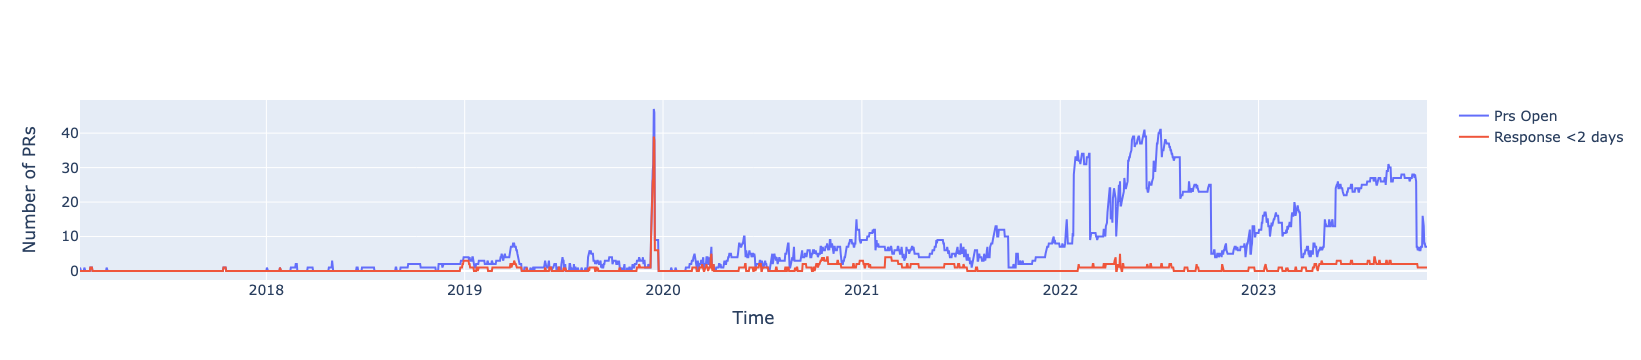

In [13]:
fig = go.Figure(
        [
            go.Scatter(
                name="Prs Open",
                x=df_pr_responses["Date"],
                y=df_pr_responses["Open"],
                mode="lines",
                showlegend=True,
                hovertemplate="PR's Open: %{y}<br>%{x|%b %d, %Y} <extra></extra>",
                #marker=dict(color=color_seq[1]),
            ),
            go.Scatter(
                name="Response <" + str(num_days) + " days",
                x=df_pr_responses["Date"],
                y=df_pr_responses["Response"],
                mode="lines",
                showlegend=True,
                hovertemplate="PRs: %{y}<br>%{x|%b %d, %Y} <extra></extra>",
                #marker=dict(color=color_seq[5]),
            ),
        ]
    )
fig.update_layout(
        xaxis_title="Time",
        yaxis_title="Number of PRs",
        font=dict(size=14),
    )